In [140]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [141]:
pip install xgboost


[notice] A new release of pip available: 22.3.1 -> 23.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [142]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
import pprint
import seaborn as sn
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


In [157]:
def drop_unwanted_columns(df):
    df = df.drop('teamID', axis=1)
    df = df.drop('inhibKills', axis=1)
    df = df.drop('towerKills', axis=1)
    df = df.drop('assists', axis=1)
    df = df.drop('game_time', axis=1)
    df = df.drop('game_id', axis=1)
    return df

In [144]:
with open('esports-data/lck_2023_average_stats.json', 'r') as json_file:
    data = json.load(json_file)

df = pd.DataFrame(data)
df = drop_unwanted_columns(df)


df

,baronKills,championsKills,deaths,dragonKills,first_blood,first_turret,totalDamage,totalGold,totalLevel,won
0,0,0.745937,0.043879,3,True,True,22695.472874,1948.695597,2.676599,True
1,0,0.043879,0.745937,0,False,False,16546.005534,1438.693820,2.457205,False
2,2,0.416064,0.388326,2,False,False,30703.887080,1916.335087,2.246745,True
3,0,0.388326,0.416064,3,True,True,23298.979904,1764.471744,2.219008,False
4,0,0.223992,0.671976,0,False,False,20090.998288,1647.796386,2.426579,False
...,...,...,...,...,...,...,...,...,...,...
465,1,0.097045,0.291136,2,False,False,27738.625310,1664.738566,2.013689,False
466,0,0.266911,0.762602,1,True,False,20916.845439,1693.699831,2.440325,False
467,1,0.762602,0.266911,2,False,True,25539.891611,2037.251813,2.745365,True
468,0,0.200154,0.533745,0,True,False,24639.841918,1735.471575,2.335134,False


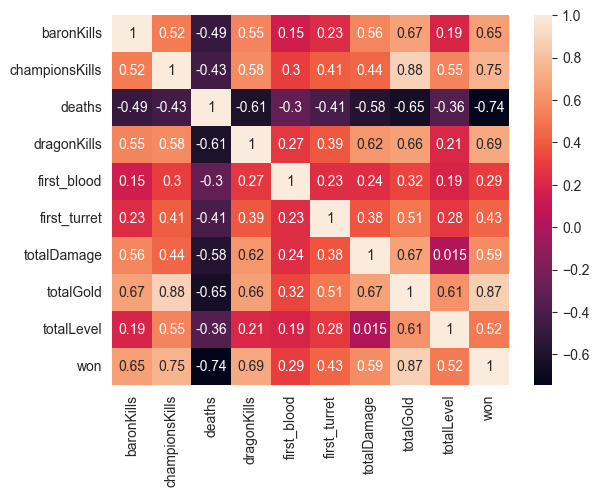

In [145]:
corrMatrix = df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [146]:
from sklearn.preprocessing import OrdinalEncoder

# Extract feature and target arrays
X, y = df.drop('won', axis=1), df[['won']]
# y = OrdinalEncoder().fit_transform(y)

In [147]:
y

,won
0,True
1,False
2,True
3,False
4,False
...,...
465,False
466,False
467,True
468,False


In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [149]:
# Create regression matrices
dtrain_clf = xgb.DMatrix(X_train, y_train)
dtest_clf = xgb.DMatrix(X_test, y_test)

In [150]:
evals = [(dtrain_clf, "train"), (dtest_clf, "validation")]


xgb_classifier = xgb.XGBClassifier(n_estimators=500, objective='binary:logistic', tree_method='hist', eta=0.07, max_depth=3, evals=evals)
xgb_classifier.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], eval_metric='logloss', verbose=True, early_stopping_rounds=50)

model = xgb_classifier.get_booster()


[0]	validation_0-logloss:0.63091	validation_1-logloss:0.63028
[1]	validation_0-logloss:0.57662	validation_1-logloss:0.57579
[2]	validation_0-logloss:0.52884	validation_1-logloss:0.52792
[3]	validation_0-logloss:0.48648	validation_1-logloss:0.48554
[4]	validation_0-logloss:0.44870	validation_1-logloss:0.44783
[5]	validation_0-logloss:0.41484	validation_1-logloss:0.41411
[6]	validation_0-logloss:0.38438	validation_1-logloss:0.38383
[7]	validation_0-logloss:0.35686	validation_1-logloss:0.35591
[8]	validation_0-logloss:0.33192	validation_1-logloss:0.33125
[9]	validation_0-logloss:0.30923	validation_1-logloss:0.30819
[10]	validation_0-logloss:0.28856	validation_1-logloss:0.28788
[11]	validation_0-logloss:0.26969	validation_1-logloss:0.26881
[12]	validation_0-logloss:0.25241	validation_1-logloss:0.25185
[13]	validation_0-logloss:0.23641	validation_1-logloss:0.23589
[14]	validation_0-logloss:0.22174	validation_1-logloss:0.22126
[15]	validation_0-logloss:0.20833	validation_1-logloss:0.20855
[1

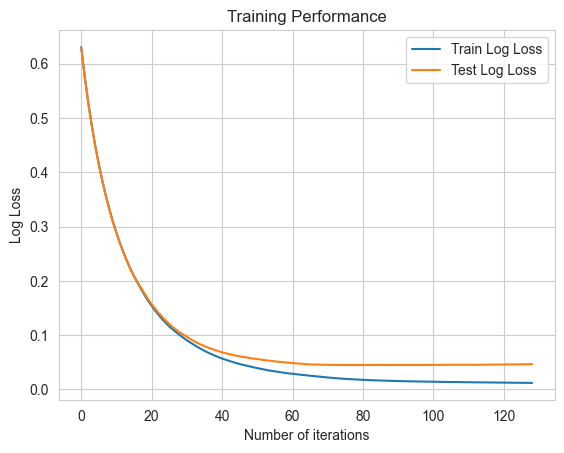

In [151]:
import matplotlib.pyplot as plt

results = xgb_classifier.evals_result()

train_error = results['validation_0']['logloss']
test_error = results['validation_1']['logloss']


x = range(len(test_error))
plt.plot(x, train_error, label='Train Log Loss')
plt.plot(x, test_error, label='Test Log Loss')
plt.xlabel('Number of iterations')
plt.ylabel('Log Loss')
plt.title('Training Performance')
plt.legend()
plt.show()

In [152]:
from sklearn.metrics import mean_squared_error

preds = model.predict(dtest_clf)

In [153]:
rmse = mean_squared_error(y_test, preds, squared=False)

In [154]:
print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 0.104


In [158]:
# with open('esports-data/lck_2023_team_average_stats.json', 'r') as json_file:
#     testing_data = json.load(json_file)
#
# with open('esports-data/teams_but_better.json', 'r') as json_file:
#     team_names = json.load(json_file)
#
#
# result_dict = dict()
#
# for team_name, team_stats in testing_data.items():
#     count = 0
#     prediction = 0
#     for entry in team_stats:
#         test = pd.DataFrame([entry])
#         test = drop_unwanted_columns(test)
#         test = test.drop('won', axis = 1)
#         test_matrix = xgb.DMatrix(test)
#         prediction += model.predict(test_matrix)
#         count += 1
#     prediction /= count
#     result_dict[team_names[team_name]] = prediction
#

with open('esports-data/lck_2023_average_stats.json', 'r') as json_file:
    testing_data = json.load(json_file)

with open('esports-data/teams_but_better.json', 'r') as json_file:
    team_names = json.load(json_file)


result_dict = dict()

for stats in testing_data:
    test = pd.DataFrame([stats])
    test = drop_unwanted_columns(test)
    test = test.drop('won', axis = 1)
    test_matrix = xgb.DMatrix(test)
    prediction = model.predict(test_matrix)
    result_dict[stats["game_id"]] = prediction


In [159]:
pprint.pprint(sorted(result_dict.items(), key=lambda x:x[1], reverse=True))


[('ESPORTSTMNT01:3372716', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT01:3373049', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT01:3375285', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT01:3375321', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT01:3385176', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT01:3386462', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT01:3413370', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT02:3215087', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT02:3219915', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT03:3170239', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT03:3199084', array([0.99877864], dtype=float32)),
 ('ESPORTSTMNT01:3408177', array([0.99876606], dtype=float32)),
 ('ESPORTSTMNT02:3217939', array([0.99876606], dtype=float32)),
 ('ESPORTSTMNT01:3380253', array([0.99875414], dtype=float32)),
 ('ESPORTSTMNT01:3409605', array([0.99875414], dtype=float32)),
 ('ESPORTSTMNT01:3415307', array([0.9987